In [1]:
import networkx as nx 
import pandas as pd 
import numpy as np 
from tqdm import tqdm

In [2]:
# data load 

# monthly index 
month_idx = pd.date_range(start='08/01/2015', end='12/01/2016', freq='MS', tz='UTC') 
month_idx_str = [m.strftime('%Y%m') for m in month_idx]

monthly_network = []

for month in tqdm(month_idx_str):
    txG = nx.read_gexf(f'/data01/storage_damini/Ethereum_network/monthly_network_{month}_PPR.gexf')

    log_value = {}
    for edge, value in nx.get_edge_attributes(txG, 'value').items():
        log_value[edge] = np.log10(value)

    nx.set_edge_attributes(txG, log_value, 'log_value')
    
    monthly_network.append(txG)

100%|██████████| 17/17 [01:58<00:00,  6.98s/it]


In [3]:
# get pagerank vector for each 
def personalized_pagerank(graph, personal_type):
    personal = {}
    normalized = {}
    dictionary = nx.get_node_attributes(graph, personal_type)

    for node in graph.nodes():
        ty = graph.nodes[node].get(personal_type)
        if ty == 1:
            personal[node] = 1
        else:
            personal[node] = 0
            
    for k in personal: 
        normalized[k] = personal[k]/sum(personal.values())
        
    pagerank = nx.pagerank(graph, alpha=0.85, personalization = personal, weight='log_value')
    nx.set_node_attributes(graph, pagerank, personal_type+"pagerank")
    return pagerank

In [5]:
genesis_distribution = []
miner_distribution = []

for network in tqdm(monthly_network):
    genesis_distribution.append(personalized_pagerank(network, "genesis"))
    miner_distribution.append(personalized_pagerank(network, "miner"))

100%|██████████| 17/17 [43:22<00:00, 153.12s/it]


In [10]:
# 계산이 왤케 어래걸리니 칭구야... 
# 뒤에까지 할려면 1시간도 더 걸리겠는데...?
# 최소 30분 확인...

In [9]:
genesis_distribution = []
miner_distribution = []

for network in tqdm(monthly_network):
    genesis_distribution.append(nx.get_node_attributes(network, "genesispagerank"))
    miner_distribution.append(nx.get_node_attributes(network, "minerpagerank"))

100%|██████████| 17/17 [00:02<00:00,  8.09it/s]


In [10]:
len(miner_distribution[0]), len(genesis_distribution[0])

(10575, 10575)

In [11]:
def euclidean_distance(vector_a, vector_b):
    distance = 0
    for node in vector_a.keys():
        distance += np.square(vector_a[node]-vector_b[node])
    return np.sqrt(distance)


# Calculate distance
from scipy.spatial.distance import jensenshannon, cosine # means cosine distance

euclidean_list = []
js_list = []
cos_list =[]
cos_2 = []

for i, network in enumerate(monthly_network):
#     sorted_genesis = sorted(genesis_distribution[i].items())
#     sorted_miner = sorted(miner_distribution[i].items())
#     genesis_distribution[i] = collections.OrderedDict(sorted_genesis)
#     miner_distribution[i] = collections.OrderedDict(sorted_miner)
    
    euclidean_list.append(euclidean_distance(genesis_distribution[i], miner_distribution[i]))
    js_list.append(jensenshannon(list(genesis_distribution[i].values()), list(miner_distribution[i].values())))
    cos_list.append(cosine(list(genesis_distribution[i].values()), list(miner_distribution[i].values())))
    cos_2.append((1-cos_list[i]))
    

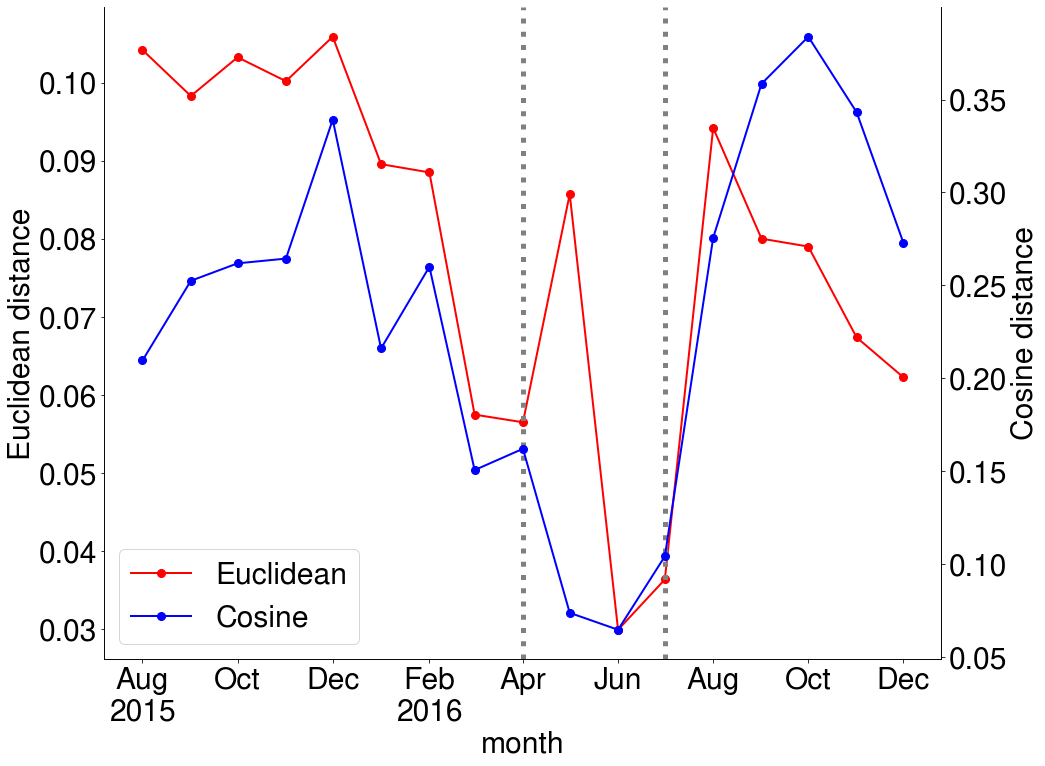

In [42]:
showdate = month_idx[[0,2,4,6,8,10,12,14,16]]
# showmonth = np.array(month_idx)[[0,2,4,6,8,10,12,14,16]]
# xticks = np.array(month_idx_str)[[0,2,4,6,8,10,12,14,16]]

import matplotlib.pyplot as plt 

plt.rcParams["figure.figsize"] = (15, 12)
# plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Nimbus Sans"]
plt.rcParams["font.size"] = 30
plt.rc('xtick', labelsize=30)
plt.rc('ytick', labelsize=30)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

similarity = [euclidean_list, cos_list]
labels = ["Euclidean", "Cosine"]
colors = ["r", "b", "k"]

for i, ax in enumerate([ax1, ax2]):
    line = ax.plot(month_idx, similarity[i], marker="o", markersize=8, linewidth=2, color=colors[i], label=labels[i])
#     ax.tick_params(axis='x', labelrotation=45)
    ax.spines['top'].set_visible(False)

    ax.set_xticks(showdate)
    ax.set_xticklabels([ts.strftime('%b\n%Y') if ts.year != showdate[idx-1].year
                else ts.strftime('%b') for idx, ts in enumerate(showdate)])
    
    ax.set_ylabel(labels[i] + ' distance')
    ax.set_xlabel('month')

ax1.axvline(x=month_idx[8], color='gray', linestyle=':', linewidth=5)
ax1.axvline(x=month_idx[11], color='gray', linestyle=':', linewidth=5)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()

ax2.legend(lines + lines2, labels + labels2, loc='lower left')

plt.savefig("../figures/distance_measure.pdf", format="pdf", bbox_inches='tight', dpi=200)

['Euclidean']

In [80]:
for month, network in zip(month_idx_str, monthly_network):
    nx.write_gexf(network, f'/data01/storage_damini/Ethereum_network/monthly_network_{month}_PPR.gexf')

In [39]:
import pandas as pd 

df = pd.read_csv('/data01/storage_damini/Ethereum_PPR/PPR_network0_genesis.csv')

len(df), len(df.columns)

(10576, 1521)

In [33]:
month_idx_str = np.array(month_idx_str)
pre_idx, post_idx = np.where(month_idx_str == '201606')[0][0], np.where(month_idx_str == '201608')[0][0]
pre_idx, post_idx

(10, 12)

In [23]:
# getting index

month_idx_str = np.array(month_idx_str)
pre_idx, post_idx = np.where(month_idx_str == '201606')[0][0], np.where(month_idx_str == '201608')[0][0]

# predf_miner = pd.read_csv(f'/data01/storage_damini/Ethereum_PPR/PPR_network{pre_idx}_miner.csv')
# predf_genesis = pd.read_csv(f'/data01/storage_damini/Ethereum_PPR/PPR_network{pre_idx}_genesis.csv')

# postdf_miner = pd.read_csv(f'/data01/storage_damini/Ethereum_PPR/PPR_network{post_idx}_miner.csv')
# postdf_genesis = pd.read_csv(f'/data01/storage_damini/Ethereum_PPR/PPR_network{post_idx}_genesis.csv')
type_ = 'miner'
type_dict = nx.get_node_attributes(monthly_network[pre_idx], type_)


In [24]:
pre_idx, post_idx

(10, 12)

In [25]:
ppr = 'minerpagerank'

pagerankdf = pd.DataFrame()

# node to type
node_type_list = ['Exchange', 'ICO', 'Token Contract', 'genesis', 'miner']
node_type_list = ['Exchange', 'ICO', 'Token Contract', 'genesis', 'miner']
node_type_df = pd.DataFrame()
for type_ in node_type_list:
    type_dict = nx.get_node_attributes(monthly_network[pre_idx], type_)
    df = pd.DataFrame.from_dict(type_dict, orient='index')
    df['type'] = type_

    node_type_df = pd.concat([node_type_df, df[['type']]])


for ppr in ['minerpagerank', 'genesispagerank']:
    df = pd.DataFrame.from_dict(nx.get_node_attributes(monthly_network[post_idx], ppr), orient='index')
    df = df.rename(columns={0:ppr})

    pagerankdf = pd.concat([pagerankdf, df], axis=1)

pagerankdf = pd.merge(pagerankdf, node_type_df, left_index=True, right_index=True, how='left')

In [70]:
# compare the mean PPR of group A, B, C 

node_type_list = ['Exchange', 'ICO', 'Token Contract', 'genesis', 'miner']
miner_PPR = pd.DataFrame()
for type_ in node_type_list:
    type_dict = nx.get_node_attributes(monthly_network[post_idx], type_)
    node_list = type_dict.keys()

    df = postdf_miner.rename(columns={'Unnamed: 0': 'nodes'})
    df = df.set_index('nodes')
    meandf = df[df.index.isin(node_list)].mean(axis=1)
    meandf = meandf.reset_index()
    meandf['type'] = type_

    miner_PPR = pd.concat([miner_PPR, meandf])

miner_PPR

,nodes,0,type
0,11379,7.706551e-07,Exchange
1,378193,0.000000e+00,Exchange
2,112830,2.093379e-10,Exchange
3,425941,0.000000e+00,Exchange
4,11668,0.000000e+00,Exchange
...,...,...,...
611,40684,8.593186e-04,miner
612,346537,8.593186e-04,miner
613,40897,8.593186e-04,miner
614,41037,8.593186e-04,miner


In [72]:
miner_PPR[miner_PPR.type == 'ICO']

,nodes,0,type
0,19527,0.00000,ICO
1,683002,0.00035,ICO


In [76]:
monthly_network[post_idx].nodes['683002'], monthly_network[post_idx].nodes['19527']

({'ICO': 1.0, 'nametag': 'Iconomi: MultiSig 2', 'label': '683002'},
 {'ICO': 1.0, 'nametag': 'Augur: Wallet', 'label': '19527'})

In [1]:
import seaborn as sns
sns.__version__ 

'0.12.2'

In [53]:
pagerankdf.type.value_counts()

genesis           891
miner             616
Exchange           28
ICO                 2
Token Contract      1
Name: type, dtype: int64

In [20]:
plotdf

,type,variable,value
0,genesis,minerpagerank,0.000000e+00
1,None,minerpagerank,0.000000e+00
2,None,minerpagerank,8.534185e-08
3,None,minerpagerank,8.259723e-08
4,None,minerpagerank,1.667005e-07
...,...,...,...
224973,None,genesispagerank,1.692996e-13
224974,None,genesispagerank,5.182659e-10
224975,None,genesispagerank,8.114954e-14
224976,None,genesispagerank,0.000000e+00


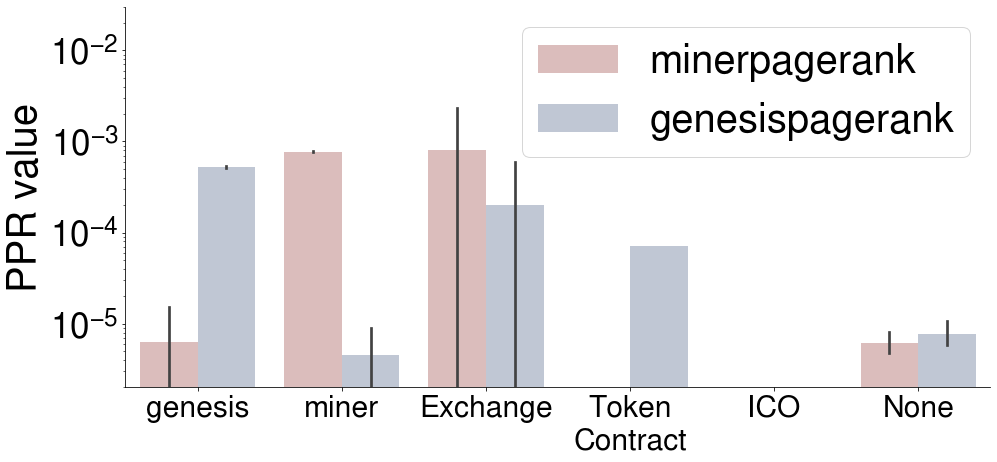

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 40
plt.rcParams["figure.figsize"] = (15.5,7)

pagerankdf = pagerankdf.fillna('None')
plotdf = pd.melt(pagerankdf, id_vars=['type'], value_vars=['minerpagerank', 'genesispagerank'])
plotdf['type'] = plotdf['type'].map(lambda x: 'Token\nContract' if x == 'Token Contract' else x)
ax = sns.barplot(data=plotdf, x='type', y='value', order=['genesis', 'miner', 'Exchange', 'Token\nContract', 'ICO', 'None'],
            hue='variable', palette='vlag_r', 
            errorbar=("ci", 95)
            )

plt.yscale('log')
plt.ylabel('PPR value')
plt.xlabel('')

plt.ylim(0.000002, 0.03)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.yticks(fontsize=35)

ax.legend_.remove()
plt.legend(loc='upper right')

plt.savefig("../figures/pagerank_201606_label.pdf", format="pdf", bbox_inches='tight', dpi=200)

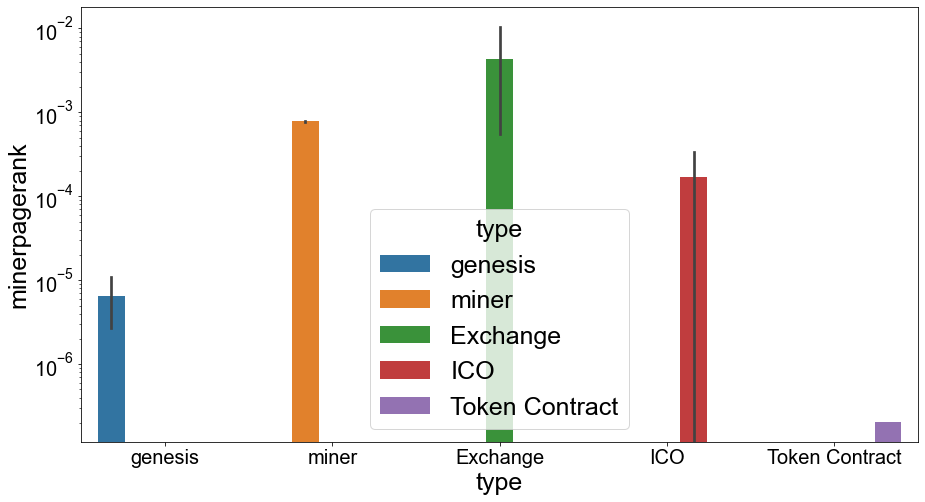

In [43]:


sns.barplot(data=pagerankdf, x='type', y='minerpagerank', hue='type')
plt.yscale('log')

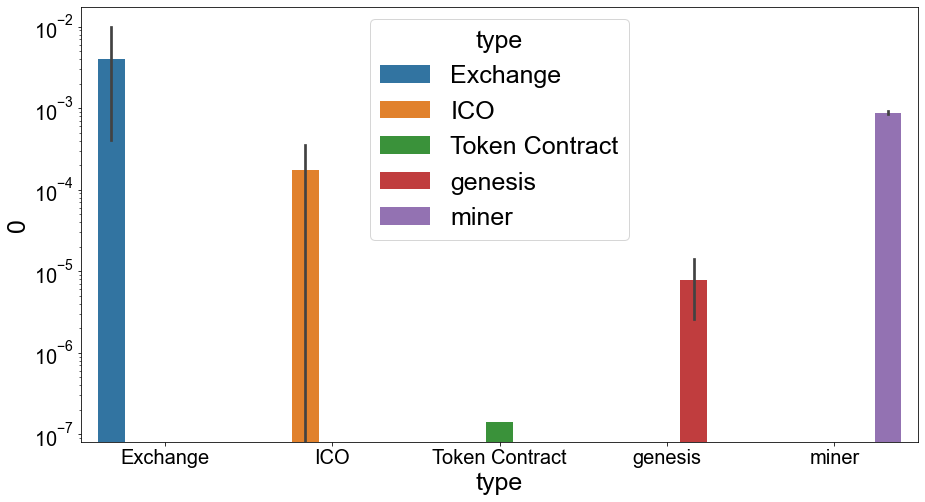

In [71]:
sns.barplot(data=miner_PPR, x='type', y=0, hue='type')
plt.yscale('log')

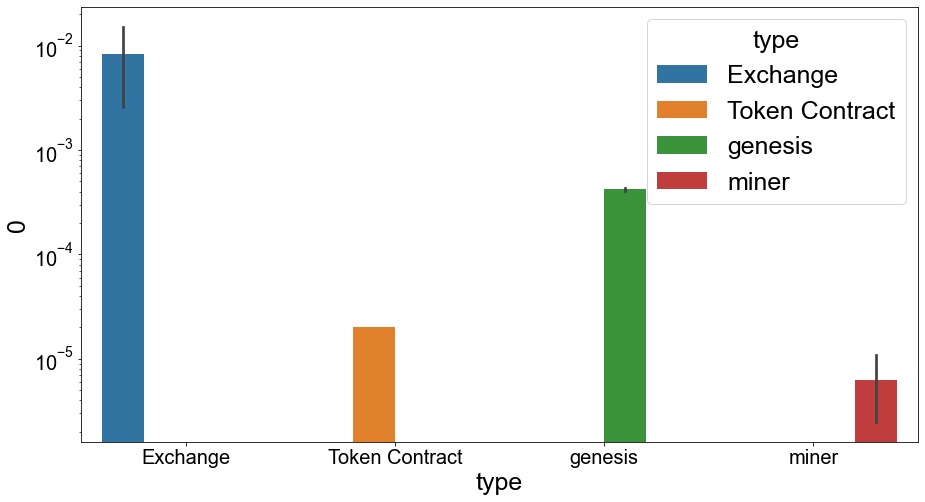

In [67]:
sns.barplot(data=miner_PPR, x='type', y=0, hue='type')
plt.yscale('log')

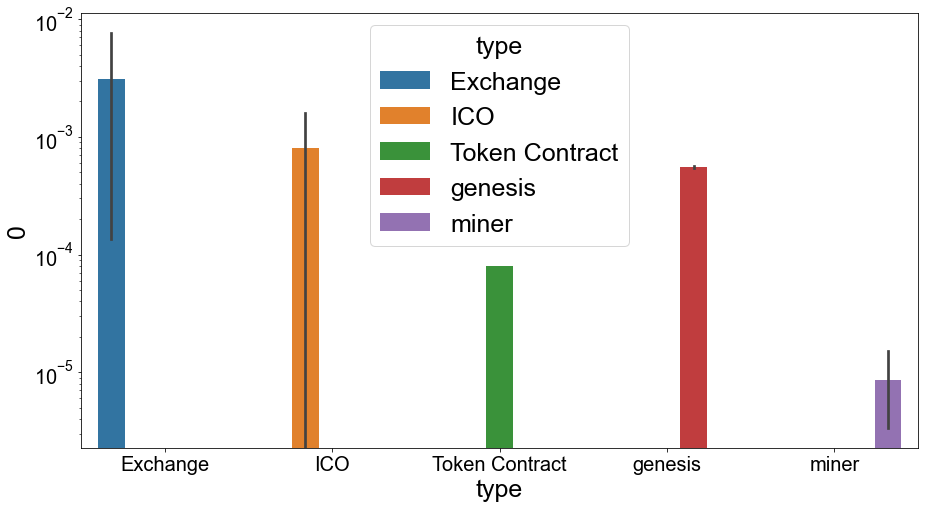

In [69]:
sns.barplot(data=miner_PPR, x='type', y=0, hue='type')
plt.yscale('log')

In [48]:
node_attr = {k for attr_dict in txG.nodes.data()._nodes.values() for k in attr_dict.keys()}
node_attr

{'Exchange', 'ICO', 'Token Contract', 'genesis', 'label', 'miner', 'nametag'}

In [53]:
predf_miner.mean(axis=1)

0          15.643736
1           0.001376
2           0.026034
3          15.921115
4           0.041098
             ...    
114303    474.679454
114304    474.680822
114305    474.682194
114306    474.683562
114307    474.684933
Length: 114308, dtype: float64